# Probability and Statistics Report

## Introduction

Our team is interested in analysing what factors positively or negatively affect academic success of university students. In our proposal, we explained that we wanted to collect multiple habits and metrics from students and analyse how each of those metrics have an impact of GPA. However, after learning about hypothesis testing we realised that our hypthesis was wrongly formulated and outside the scope and requirements of this project. So we revised our hypothesis.
<br><br>
Lets, start from the begining. Our target population is undergraduate university students who attend any of the following universities schools: Concordia, McGill, UQAM, UdeM, Sherbrooke. The feature we are interesting in investigating is GPA. 
<br><br>
We created a survey and asked the following questions:
<br>
1. What faculty are you in?

2. On average how many courses do you take per semester? (only take into account fall/winter semesters)

3. How many hours do you work per week at a job unrelated to school?

4. On average, how many days in a week do you not study at all? By studying we mean any work that you do for school. Don't include attending lectures/tutorials/labs
5. On a day that you do study, how many hours do you study?
6. What is the scale of your GPA (out of 4.3 or 4.0)?
7. Finally, what is your gpa?

After a lot of discussion and asking around, we made an educated guess that the average GPA is 3.2



## Data pre-processing
Before starting any numerical analysis, we have to clean the collected data so that it is ready for statistical analysis. 
<br>
Below is just some boiler plate code importing the libraries that we need and performing some setup.
<br><br>
You can skip to our *Statistical analysis* section.


In [28]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit

from matplotlib import pyplot as plt

import math
import csv
import scipy.stats as stats

Z_from_probability = stats.norm.ppf
probability_of_Z = stats.norm.cdf

# list respondents who gave fake answers or made mistakes in answering.
# They have to be removed from the analysis in order not to skew the results
blacklisted_emails = [
    'CleanYourData@Hal3anneh.com',
    'nope@hotmail.com',
    'eyePISSEDandFARDEDandSHIDDEDandCAMEallOVERthePLACE@lmao.pwned.com',
    'chadi.sargi@gmail.com'
]

original_survey = "./data/condensed.actual.latest.csv"
numerical_survey = './data/condensed.numerical.latest.csv'

### Cleaning Data
This function cleans the data from the csv file. We remove all emails for anonymity and unecessary metadata.

In [31]:
def clean(survey_filename: str):
    '''
    Remove the data points where people purpusefully tried to lie.
    Remove all metadata unrelated to business logic
    '''
    file = survey_filename
    numerical_raw_survey = pd.read_csv(file)
    total_rows = len(numerical_raw_survey.index)

    #print(total_rows)

    indexes_to_be_removed = []

    for i in range(1, total_rows):
        email_of_respondent = numerical_raw_survey.iloc[i, 17]
        gpa_of_respondent = float(numerical_raw_survey.iloc[i, 16])
        if email_of_respondent in blacklisted_emails or gpa_of_respondent <= 0.1:
            indexes_to_be_removed.append(i)

    numerical_raw_survey = numerical_raw_survey.drop(
        axis=0, index=indexes_to_be_removed)
    #print(len(numerical_raw_survey.index))

    # only keep answers to survey questions, exclude the faculty question
    # 17 is the index of the email column
    responses = numerical_raw_survey.iloc[1:, list(range(11, 17))]

    # cast string entries to float
    responses = pd.DataFrame.astype(responses, float)
    return responses




# Generate the dataframe object to be analysed
data = clean(numerical_survey)

## Statistical analysis


#### First, let's just plot the GPAs on the y-axis against the respondents on the x-axis
i.e. a point (x,y) just means that the x-th respondent has a GPA of y

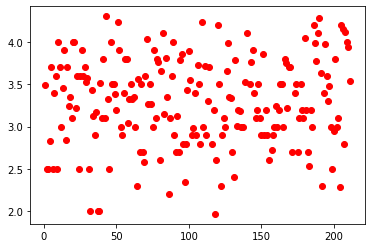

In [30]:
def plot_gpas_alone(data):
    questions = data.columns
    plt.plot(data[questions[5]], 'ro')
    plt.show()

plot_gpas_alone(data)

You can see that the lowest gpas are a little bellow 2 and the highest is 4.3 with a little over 200 respondents

### Basic sample attributes
Next up, we write the code for extracting crucial information for our analysis. Namely, we are looking for sample mean, variance, standard deviation, and median.

In [32]:
# extract GPAs from dataframe
def gpa_list(data):
    return list(data.iloc[:, 5])

def sample_size(data):
    return len(data.index)

def mean_gpa(data):
    gpas = gpa_list(data)
    sample_mean = sum(gpas)/len(gpas)
    return sample_mean


def sample_gpa_variance(data):
    # Extract gpas as numpy array to propagate math operations without looping
    # over each element.
    gpas = np.array(gpa_list(data))
    variance = (sum(gpas**2) - sum(gpas)**2/len(gpas)) / (len(gpas)-1)
    return variance


def std_dev_gpa(data):
    return math.sqrt(sample_gpa_variance(data))


def median_gpa(data):
    gpas = gpa_list(data)
    midpoint = int(len(gpas)/2)
    if len(gpas) % 2 == 0:
        return gpas[midpoint]
    lower = gpas[midpoint]
    upper = gpas[midpoint+1]
    median = (lower+upper)/2
    return median


#### Now let's compute them and print them
$\bar{x}$, $S^{2}$, $S$ and median are show below: 

In [35]:
n = sample_size(data)
xbar = round(mean_gpa(data),3)
S_squared = round(sample_gpa_variance(data),3)
S = round(std_dev_gpa(data),3)

print("sample size:", n)
print("mean:", xbar)
print("variance:", S_squared)
print("standard dev:", S)
print("median:", median_gpa(data))

sample size: 206
mean: 3.289
variance: 0.269
standard dev: 0.518
median: 3.4


In [10]:

def calculate_Z_value(mu0, X_bar, S, n):
    # because our sample size is greater than 200, we feel confident of
    # estimating sigma using S. In this way we can use the Z-distribution
    # instead of the T-distribution. This is often done when n > 30.
    Z = (X_bar - mu0)/(S/math.sqrt(n))
    return Z


def calculate_p_value(data, mu0=3.2):
    X_bar = mean_gpa(data)
    S = std_dev_gpa(data)
    n = sample_size(data)
    Z = abs(calculate_Z_value(mu0, X_bar, S, n))
    p_value = 2*probability_of_Z(-Z)
    return p_value, Z


def find_Z_alpha(confidence):
    alpha = 1-confidence
    Z_alpha_over2 = abs(Z_from_probability(1-alpha/2))
    return alpha, Z_alpha_over2


def beta_error(Zalpha2, sigma, n, mu0=3.2, mu1=3.3):
    old_Z = abs(Zalpha2)
    diff = mu1-mu0
    beta = probability_of_Z(old_Z-(diff*math.sqrt(n)/sigma))
    return beta

### Testing for Normality
Since practically forever, We have been hearing profs say that they create normal distributions out of final percent grades to assign letter grades. Because GPA is technically just a linear combination of final grades, there is a high chance that it is also normally distributed.
<br><br>
However, we did not want to make such an assumption without first seeing some evidence to back it up.
<br><br>
To test for normality we will use a technique called normal plotting. First sort all GPAs in order and assign them a value j corresponding to their order in the list (i.e. the smallest GPA is assigned ```j = 1``` and the largest GPA is assigned ```j = n```, where n is the number of total GPAs. By computing the bellow formula and plotting it's result against the corresponding GPAs we can visualise the data distribution. If a linear regression closely approximates the data than it is safe to assume that the underlying data is normally distributed.
<br><br>
The functions bellow uses the following procedure to test sample data.
<br><br>
 
\begin{align}
Y_{j} = \frac{(j - 0.5)}{n} \\
X_{j} = GPA_{j}
\end{align}

```For each j from 1 to n plot``` \begin{align}(x_{j},y_{j})\end{align}

In [38]:
def normal_plot(data):
    gpas = gpa_list(data)
    print(type("gpa type:",gpas))
    js = [j+1 for j in range(0, len(gpas))]
    prob_dis = [(j-0.5) / (len(js)) for j in js]
    plt.scatter(gpas, prob_dis, s=7, alpha=0.5)
    plt.show()
    plt.figure()

    b, m = polyfit(gpas, prob_dis, 1)
    plt.plot(gpas, prob_dis)
    plt.plot(gpas, b + m * gpas, '-')
    plt.show()

In [39]:
sr = pd.read_csv("./data/condensed.actual.latest.csv")
sr.drop(sr.index[0], inplace=True)
sr['Finally, what is your gpa?'] = pd.to_numeric(sr['Finally, what is your gpa?'])
gpas = sr['Finally, what is your gpa?']
gpa_copy = gpas.sort_values()
gpa_copy = gpa_copy.drop_duplicates()
gpa_copy = gpa_copy.iloc[2:]

normal_plot(data)

TypeError: type() takes 1 or 3 arguments

sample size: 206
mean: 3.289330097087381
variance: 0.2687755002604673
standard dev: 0.5184356278849548
median: 3.4


## Hypothesis Testing
### Step 1-3
For this study, the $\mu$ of the gpas collected is our parameter of interest and we settled decided to conduct a two-sided test because, if we are wrong, we don't know in advance if the population mean is higher or lower than our initial guess.
<br> <br>
$H_{0}$: $\mu = 3.2$ 
<br>
$H_{1}$: $\mu \neq 3.2$
<br>


### Normal Testing Our Data
Before proceding to step 4 of our testing, lets perform the normal test mentioned previously.

Text(0.5, 1.0, 'Normal Test')

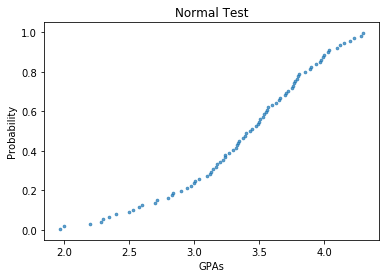

In [17]:
js = [j+1 for j in range(0, len(gpa_copy))]
prob_dis = [(j-0.5) / (len(js)) for j in js]

plt.scatter(gpa_copy, prob_dis, s=7, alpha=0.7)
plt.xlabel('GPAs')
plt.ylabel('Probability')
plt.title('Normal Test')

Text(0.5, 1.0, 'Best Fit Line')

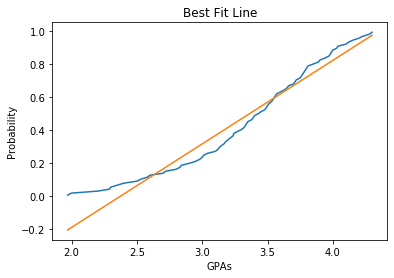

In [18]:
b, m = polyfit(gpa_copy, prob_dis, 1)
plt.plot(gpa_copy, prob_dis)
plt.plot(gpa_copy, b + m * gpa_copy, '-')
plt.xlabel('GPAs')
plt.ylabel('y_j')
plt.title('Best Fit Line')

Thus, blabalba normal distribution.

### Step 4 
Our sample size is $n = 211$.
<br>
Therefore we can use the Z-distribution since the sample size is large enough. 
<br>
$Z_{ \alpha / 2}= \frac{\mu - \bar{x}}{s / \sqrt{n}}$

### Step 5
Our sample size is large enough, thus we decided to use $\alpha = 0.02$ for our confidence level.
<br>
Our resulting critical values $\pm Z_{ \alpha / 2} $ are:

In [21]:
alpha, cutoff_Z = find_Z_alpha(0.98)
alpha = round(alpha,3)
cutoff_Z = round(cutoff_Z,3)
print("alpha:", alpha)
print("Z alpha/2:", cutoff_Z)

alpha: 0.02
Z alpha/2: 2.326


Thus, if our test statistic $Z_{0} < -2.33$ or $Z_{0} > 2.33$, we will reject our null hypthesis.

### Step 6
Now, we compute our test statistic $Z_{0}$:

In [18]:
mu0=3.2
p_value, actual_Z = calculate_p_value(cleaned, mu0=mu0)
print("actual Z:", actual_Z)


actual Z: 2.473070954112705


### Step 7
Lets compute the p-value before drawing our conclusion.

In [19]:
print("p_value:", p_value)

p_value: 0.013395754395141526


$p < \alpha$, thus we have enough evidence to our reject our null hypothesis <br>
$H_{0}$: $\mu_{0} = 3.2$

### Analysing Type I & II Error
We saw that our type I error was $0.02$ or $2 \%$ of rejecting our $H_{0}$ when it is true. 
<br>
Now, we will compute our type II error assuming the true $\mu = 3.3$.
<br>
Following the formula for $\beta$
\begin{align}
\beta = \phi[Z_{ \alpha / 2} - \frac{\delta\sqrt(n)}{s}] - \phi[-Z_{ \alpha / 2} - \frac{\delta\sqrt(n)}{s}]
\end{align}
Gives us:

In [22]:
beta = beta_error(cutoff_Z, S, n)
print("beta error:", round(beta,3))
print("power of test:", round(1-beta,3))

beta error: 0.329
power of test: 0.671


We see that we have $33\%$ chance of accepting our $H_{0}$ when it is false. 
<br>
Thus, we do not have enough evidence to reject $H_{1}: \mu \neq 3.2$